<a href="https://colab.research.google.com/github/ragul1995/NLP_with_Python/blob/master/DistillBert_with_Ktrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using ktrain

***ktrain*** requires TensorFlow 2.


Why **ktrain**?

ktrain now includes a simplified interface to Hugging Face transformers for text classification. I will show you how you can build, train, and deploy a text classification model with Hugging Face transformers in only a few lines of code.

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
#Code for checking what type of device we run our model
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

We then need to install *ktrain* library using pip.

In [0]:
#!pip3 install ktrain

Cool!. Now that we have installed ktrain. we move on to extract data for classification.

### Load a Dataset Into Arrays

In [0]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']
from sklearn.datasets import fetch_20newsgroups
train_b = fetch_20newsgroups(subset='train',
   categories=categories, shuffle=True, random_state=42)
test_b = fetch_20newsgroups(subset='test',
   categories=categories, shuffle=True, random_state=42)

print('size of training set: %s' % (len(train_b['data'])))
print('size of validation set: %s' % (len(test_b['data'])))
print('classes: %s' % (train_b.target_names))

x_train = train_b.data
y_train = train_b.target
x_test = test_b.data
y_test = test_b.target

size of training set: 2257
size of validation set: 1502
classes: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


##Preprocess Data and Create a Transformer Model

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [0]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=train_b.target_names)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:367: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')



preprocessing train...
language: en
train sequence lengths:
	mean : 308
	95percentile : 837
	99percentile : 1938


preprocessing test...
language: en
test sequence lengths:
	mean : 343
	95percentile : 979
	99percentile : 2562


## Estimate a Good Learning Rate

Learning rates between 2e-5 and 5e-5 tend to work well with transformer models based on papers from Google. However, we will run our learning-rate-finder for two epochs to estimate the LR.
As shown below, our results are consistent Google's findings.

simulating training for different learning rates... this may take a few moments...
Train for 376 steps
Epoch 1/2
376/376 [==============================] - 90s 238ms/step - loss: 1.1175 - accuracy: 0.4809
Epoch 2/2
206/376 [===============>..............] - ETA: 37s - loss: 2.2628 - accuracy: 0.2689

done.
Visually inspect the loss plot to help identify the maximal learning rate


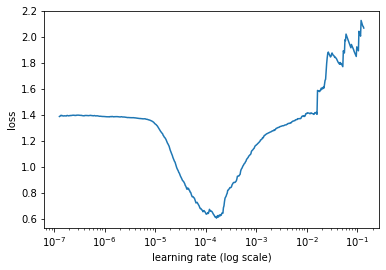

In [0]:
learner.lr_find(show_plot=True, max_epochs=2)

##Train the Model

In [0]:
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Train for 377 steps, validate for 47 steps
Epoch 1/4
377/377 [==============================] - 100s 266ms/step - loss: 0.6911 - accuracy: 0.7466 - val_loss: 0.1749 - val_accuracy: 0.9467
Epoch 2/4
377/377 [==============================] - 98s 261ms/step - loss: 0.1624 - accuracy: 0.9544 - val_loss: 0.1603 - val_accuracy: 0.9527
Epoch 3/4
377/377 [==============================] - 98s 261ms/step - loss: 0.0636 - accuracy: 0.9818 - val_loss: 0.1533 - val_accuracy: 0.9507
Epoch 4/4
377/377 [==============================] - 98s 261ms/step - loss: 0.0219 - accuracy: 0.9942 - val_loss: 0.2213 - val_accuracy: 0.9427


##Evaluate and Inspect the Model

In [0]:
learner.validate(class_names=t.get_classes())

                        precision    recall  f1-score   support

           alt.atheism       0.88      0.91      0.90       319
         comp.graphics       0.99      0.93      0.96       389
               sci.med       0.98      0.94      0.96       396
soc.religion.christian       0.92      0.98      0.95       398

              accuracy                           0.94      1502
             macro avg       0.94      0.94      0.94      1502
          weighted avg       0.94      0.94      0.94      1502



array([[291,   1,   3,  24],
       [ 19, 361,   6,   3],
       [ 15,   3, 373,   5],
       [  6,   1,   0, 391]])

Let's examine the validation example about which we were the most wrong.

In [0]:
learner.view_top_losses(n=1, preproc=t)

----------
id:1393 | loss:7.17 | true:comp.graphics | pred:alt.atheism)



In [0]:
print(x_test[371])

From: kempmp@phoenix.oulu.fi (Petri Pihko)
Subject: Re: Consciousness part II - Kev Strikes Back!
Organization: University of Oulu, Finland
X-Newsreader: TIN [version 1.1 PL9]
Lines: 30

Scott D. Sauyet (SSAUYET@eagle.wesleyan.edu) wrote:
> In <1993Apr21.163848.8099@cs.nott.ac.uk> 
> Kevin Anthony (kax@cs.nott.ac.uk) writes:

> > Firstly, I'm not impressed with the ability of algorithms. They're
> > great at solving problems once the method has been worked out, but not
> > at working out the method itself.
>   [ .. crossword example deleted ... ]

> Have you heard of neural networks?  I've read a little about them, and
> they seems to overcome most of your objections.

I'm sure there are many people who work with neural networks and
read this newsgroup. Please tell Kevin what you've achieved, and
what you expect.

> I am not saying that NNs will solve all such problems, but I think
> they show that it is not as hard as you think to come up with
> mechanical models of consciousness.

In

This post talks more about computing than `alt.atheism` (the true category), so our model placed it into the only computing category available to it: `comp.graphics`

##Making Predictions on New Data in Deployment

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [0]:
predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [0]:
# predicted probability scores for each category
predictor.predict_proba('Jesus Christ is the central figure of Christianity.')

array([4.5372783e-03, 6.3316879e-04, 8.3456148e-04, 9.9399501e-01],
      dtype=float32)

In [0]:
predictor.get_classes()

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

As expected, `soc.religion.christian` is assigned the highest probability.

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [0]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


In [0]:
predictor.explain('Jesus Christ is the central figure in Christianity.')

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.

We can save and reload our predictor for later deployment.

In [0]:
predictor.save('/tmp/my_distilbert_predictor')

In [0]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_distilbert_predictor')

In [0]:
reloaded_predictor.predict('My computer monitor is really blurry.')

'comp.graphics'

In [0]:
predictor.explain('My computer monitor is really blurry.')